In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import seaborn as sns

In [29]:
url = "https://raw.githubusercontent.com/digipodium/Datasets/main/regression/house_pricing.csv"
df = pd.read_csv(url)
df.head()

,City,Type,Beds,Baths,SquareFeet,Price
0,SACRAMENTO,Residential,2,1,836,138159.85
1,SACRAMENTO,Residential,3,1,1167,167541.46
2,SACRAMENTO,Residential,2,1,796,119095.12
3,SACRAMENTO,Residential,2,1,852,130904.95
4,SACRAMENTO,Residential,2,1,797,120266.19


 positively correlated data

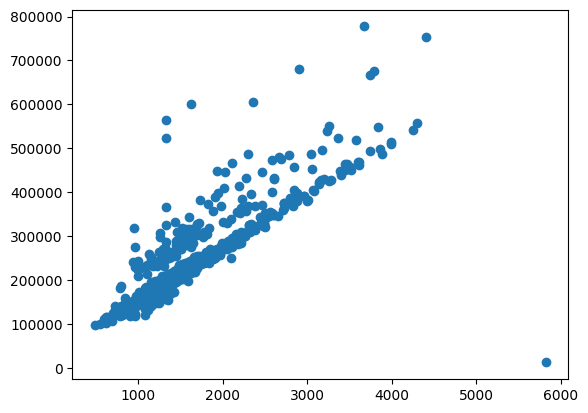

In [30]:
plt.scatter(df.SquareFeet, df.Price)

feature analysis
> check correlation between features and target when data is numeric

pearson correlation cofficient
- if value close to 1, strong +ve correlation
- if value close to -1, strong -ve correlation
- if value close to 0, no correlation 

Pearson coffecient: 0.8517550354760816


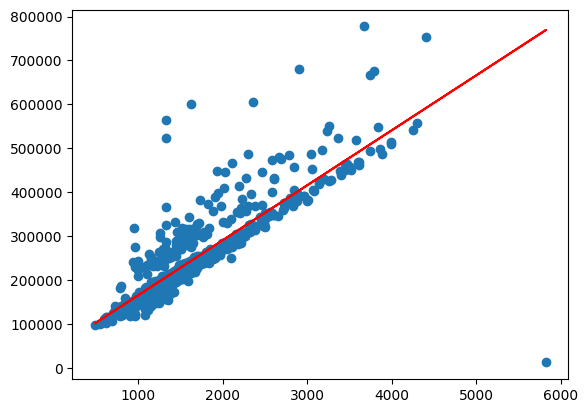

In [31]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(df[['SquareFeet']], df.Price)
pred = model.predict(df[['SquareFeet']])
plt.scatter(df.SquareFeet, df.Price)
plt.plot(df.SquareFeet, pred, color='red')
# pearson correlation
pc = df.SquareFeet.corr(df.Price)
print('Pearson coffecient:',pc)

In [32]:
df.select_dtypes(include='number').corrwith(df.Price)

Beds          0.609677
Baths         0.632218
SquareFeet    0.851755
Price         1.000000
dtype: float64

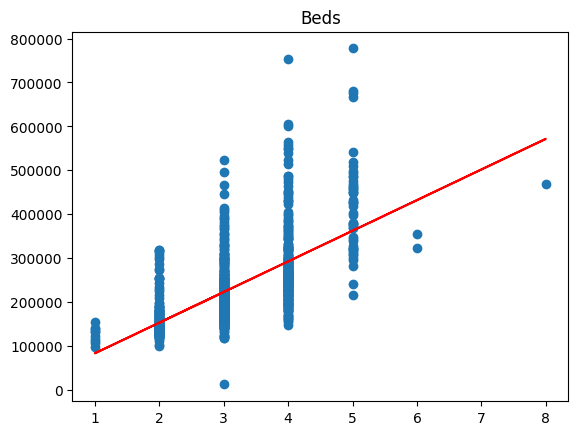

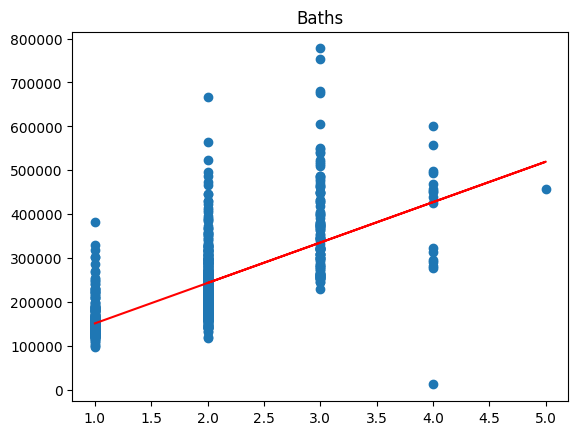

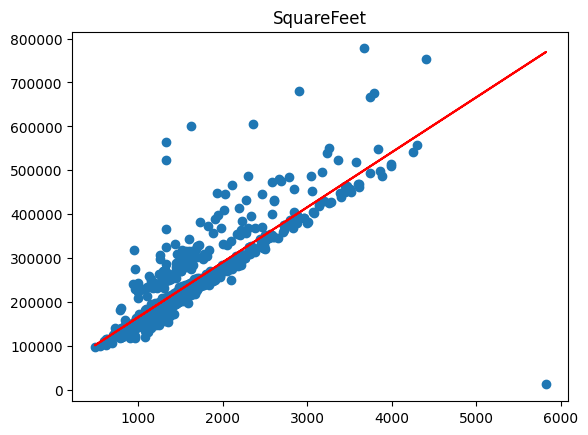

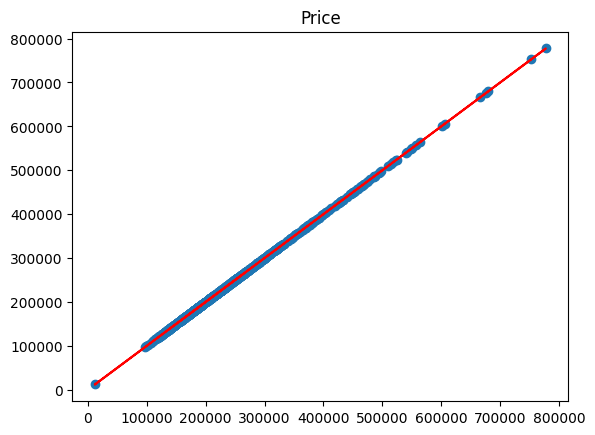

In [33]:
num_cols = df.select_dtypes(include='number').columns
for col in num_cols:
    plt.scatter(df[col], df.Price)
    plt.title(col)
    model = LinearRegression()
    model.fit(df[[col]], df.Price)
    plt.plot(df[col], model.predict(df[[col]]), color='red')
    plt.show()

- for categorical independent variable with numerical target
    - boxplot analysis (visual)
    - anova test
        - null hypothesis : means of the groups are equal
        - if p-value < 0.05, reject null hypothesis
        - if p-values > 0.05, fail to reject null hypothesis

In [34]:
df.columns

Index(['City', 'Type', 'Beds', 'Baths', 'SquareFeet', 'Price'], dtype='object')

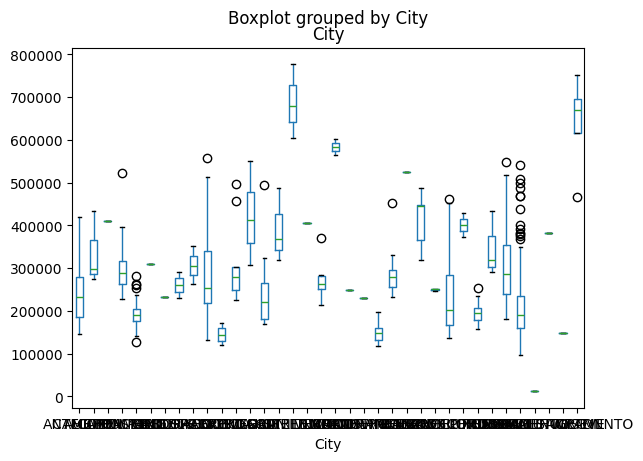

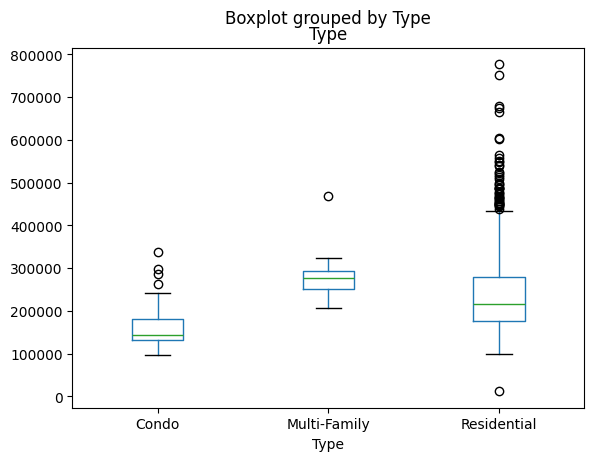

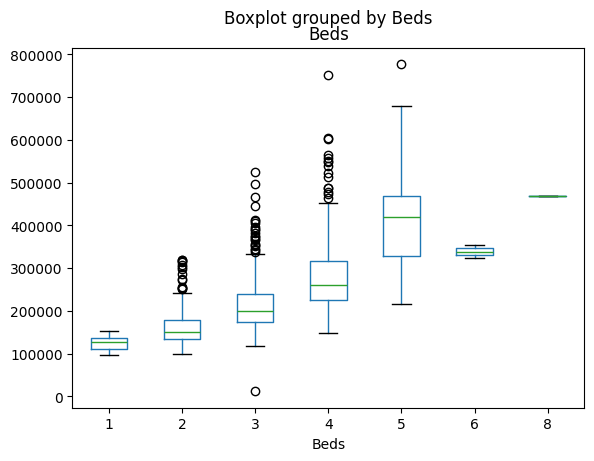

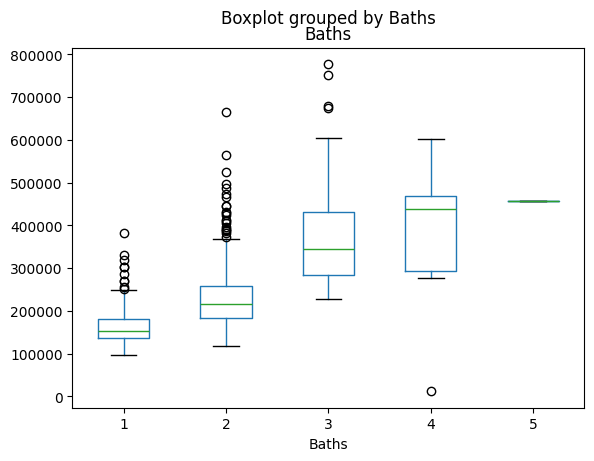

In [35]:
cat_cols = ['City', 'Type', 'Beds', 'Baths']
for col in cat_cols:
    df.boxplot(column='Price', by=col, grid=False)
    plt.title(col)


### testing with anova
- for each features, calculate the f-statistics and p-value

In [36]:
from scipy.stats import f_oneway
for col in cat_cols:
    print(col)
    groups = df.groupby(col).groups
    data = [df.Price[groups[i]] for i in groups]
    f, p = f_oneway(*data)
    print(f'F-statistic: {f:.2f}, p-value: {p:.2f}')

City
F-statistic: 22.32, p-value: 0.00
Type
F-statistic: 13.84, p-value: 0.00
Beds
F-statistic: 92.40, p-value: 0.00
Baths
F-statistic: 156.16, p-value: 0.00


In [37]:
from statsmodels.formula.api import ols
for col in cat_cols:
    model = ols(f'Price ~ '+col, data=df).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     22.32
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           3.88e-94
Time:                        13:03:06   Log-Likelihood:                -10223.
No. Observations:                 814   AIC:                         2.052e+04
Df Residuals:                     778   BIC:                         2.069e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2

In [38]:
selected_cols = ['SquareFeet', 'Beds', 'Baths', 'Type']
X = df[selected_cols]
y = df.Price


In [39]:
X['Type'].value_counts()

Type
Residential     759
Condo            42
Multi-Family     13
Name: count, dtype: int64

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


In [41]:
num_cols = X.select_dtypes(include='number').columns
cat_cols = X.select_dtypes(include='object').columns
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('onehot', OneHotEncoder())
])
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])
model = Pipeline([
    ('pre', preprocessor),
    ('lr', LinearRegression())
])
model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['SquareFeet', 'Beds', 'Baths'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  Index(['Type'], dtype='object'))])),
                ('lr', LinearRegression())])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [43]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print("Training Results")
print("MSE:", mean_squared_error(y_train, y_train_pred))
print("R2:", r2_score(y_train, y_train_pred))
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print('-'*50)
print("Testing Results")
print("MSE:", mean_squared_error(y_test, y_test_pred))
print("R2:", r2_score(y_test, y_test_pred))
print("MAE:", mean_absolute_error(y_test, y_test_pred))


Training Results
MSE: 2139700636.4876497
R2: 0.8029163181734968
MAE: 26638.800051104565
--------------------------------------------------
Testing Results
MSE: 3926318201.2509975
R2: 0.3780547228721485
MAE: 26431.945653360133


In [44]:
import joblib
import  os
os.makedirs(os.path.join(os.getcwd(), 'models'), exist_ok=True)
# save mode - dumping
path = os.path.join(os.getcwd(), 'models', 'house_price_model')
joblib.dump(model, path)

['c:\\Users\\gaura\\OneDrive\\Desktop\\AI 2024\\AI-2024\\supervisedLearning\\models\\house_price_model']

loading a saved model

In [45]:
path = os.path.join(os.getcwd(), 'models', 'house_price_model')
joblib.load(path)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['SquareFeet', 'Beds', 'Baths'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  Index(['Type'], dtype='object'))])),
                ('lr', LinearRegression())])

making prediction with model

In [46]:
X.head()

,SquareFeet,Beds,Baths,Type
0,836,2,1,Residential
1,1167,3,1,Residential
2,796,2,1,Residential
3,852,2,1,Residential
4,797,2,1,Residential


In [47]:
# very simple example data
print(model.predict(X.head()))

[137767.10948378 178212.91980202 132317.86399559 139946.80767906
 132454.09513279]


In [48]:
# for checking unique values
print(X.Type.unique())

['Residential' 'Condo' 'Multi-Family']


In [49]:
# manual data input
X.columns.tolist()
inpX = pd.DataFrame({
    'SquareFeet': [2000],
    'Beds': [3],
    'Baths': [2],
    'Type': ['Condo']   
})
result = model.predict(inpX)
print(*result, sep='\n') # shortcut to print each element in a list in a new line

303997.4526441786


evaluating the training and testing performance of a model

[130 195 260 325 390 455 520 585]
[0.85406081 0.8855124  0.84626689 0.82188835 0.82566341 0.82046707
 0.79601211 0.7335621 ]
[0.68084434 0.69181444 0.69917174 0.69992435 0.70058582 0.70235974
 0.6989901  0.6943628 ]


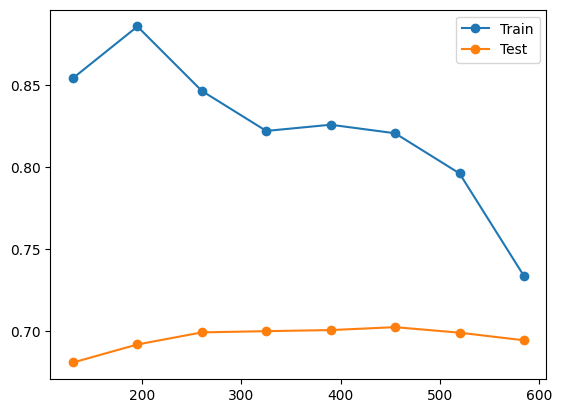

In [50]:
from sklearn.model_selection import learning_curve, cross_val_score

train_sizes = [.2 ,.3, .4,.5, .6, .7, .8, .9]
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, train_sizes=train_sizes)
print(train_sizes)
print(train_scores.mean(axis=1))
print(test_scores.mean(axis=1))

# plot learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train', marker='o')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test', marker='o')
plt.legend()
plt.show() 

making a desicion tree model, to check the updated accuracy

In [51]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [52]:
model2 = Pipeline([
    ('pre', preprocessor),
    ('dt', DecisionTreeRegressor())
])
model2.fit(X_train, y_train)
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

print("Training Results")
print("MSE:", mean_squared_error(y_train, y_train_pred))
print("R2:", r2_score(y_train, y_train_pred))
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print('-'*50)
print("Testing Results")
print("MSE:", mean_squared_error(y_test, y_test_pred))
print("R2:", r2_score(y_test, y_test_pred))
print("MAE:", mean_absolute_error(y_test, y_test_pred))

Training Results
MSE: 186260309.90986165
R2: 0.9828439235708042
MAE: 2847.283617457528
--------------------------------------------------
Testing Results
MSE: 4960199347.869689
R2: 0.21428361128823614
MAE: 32863.02504761904


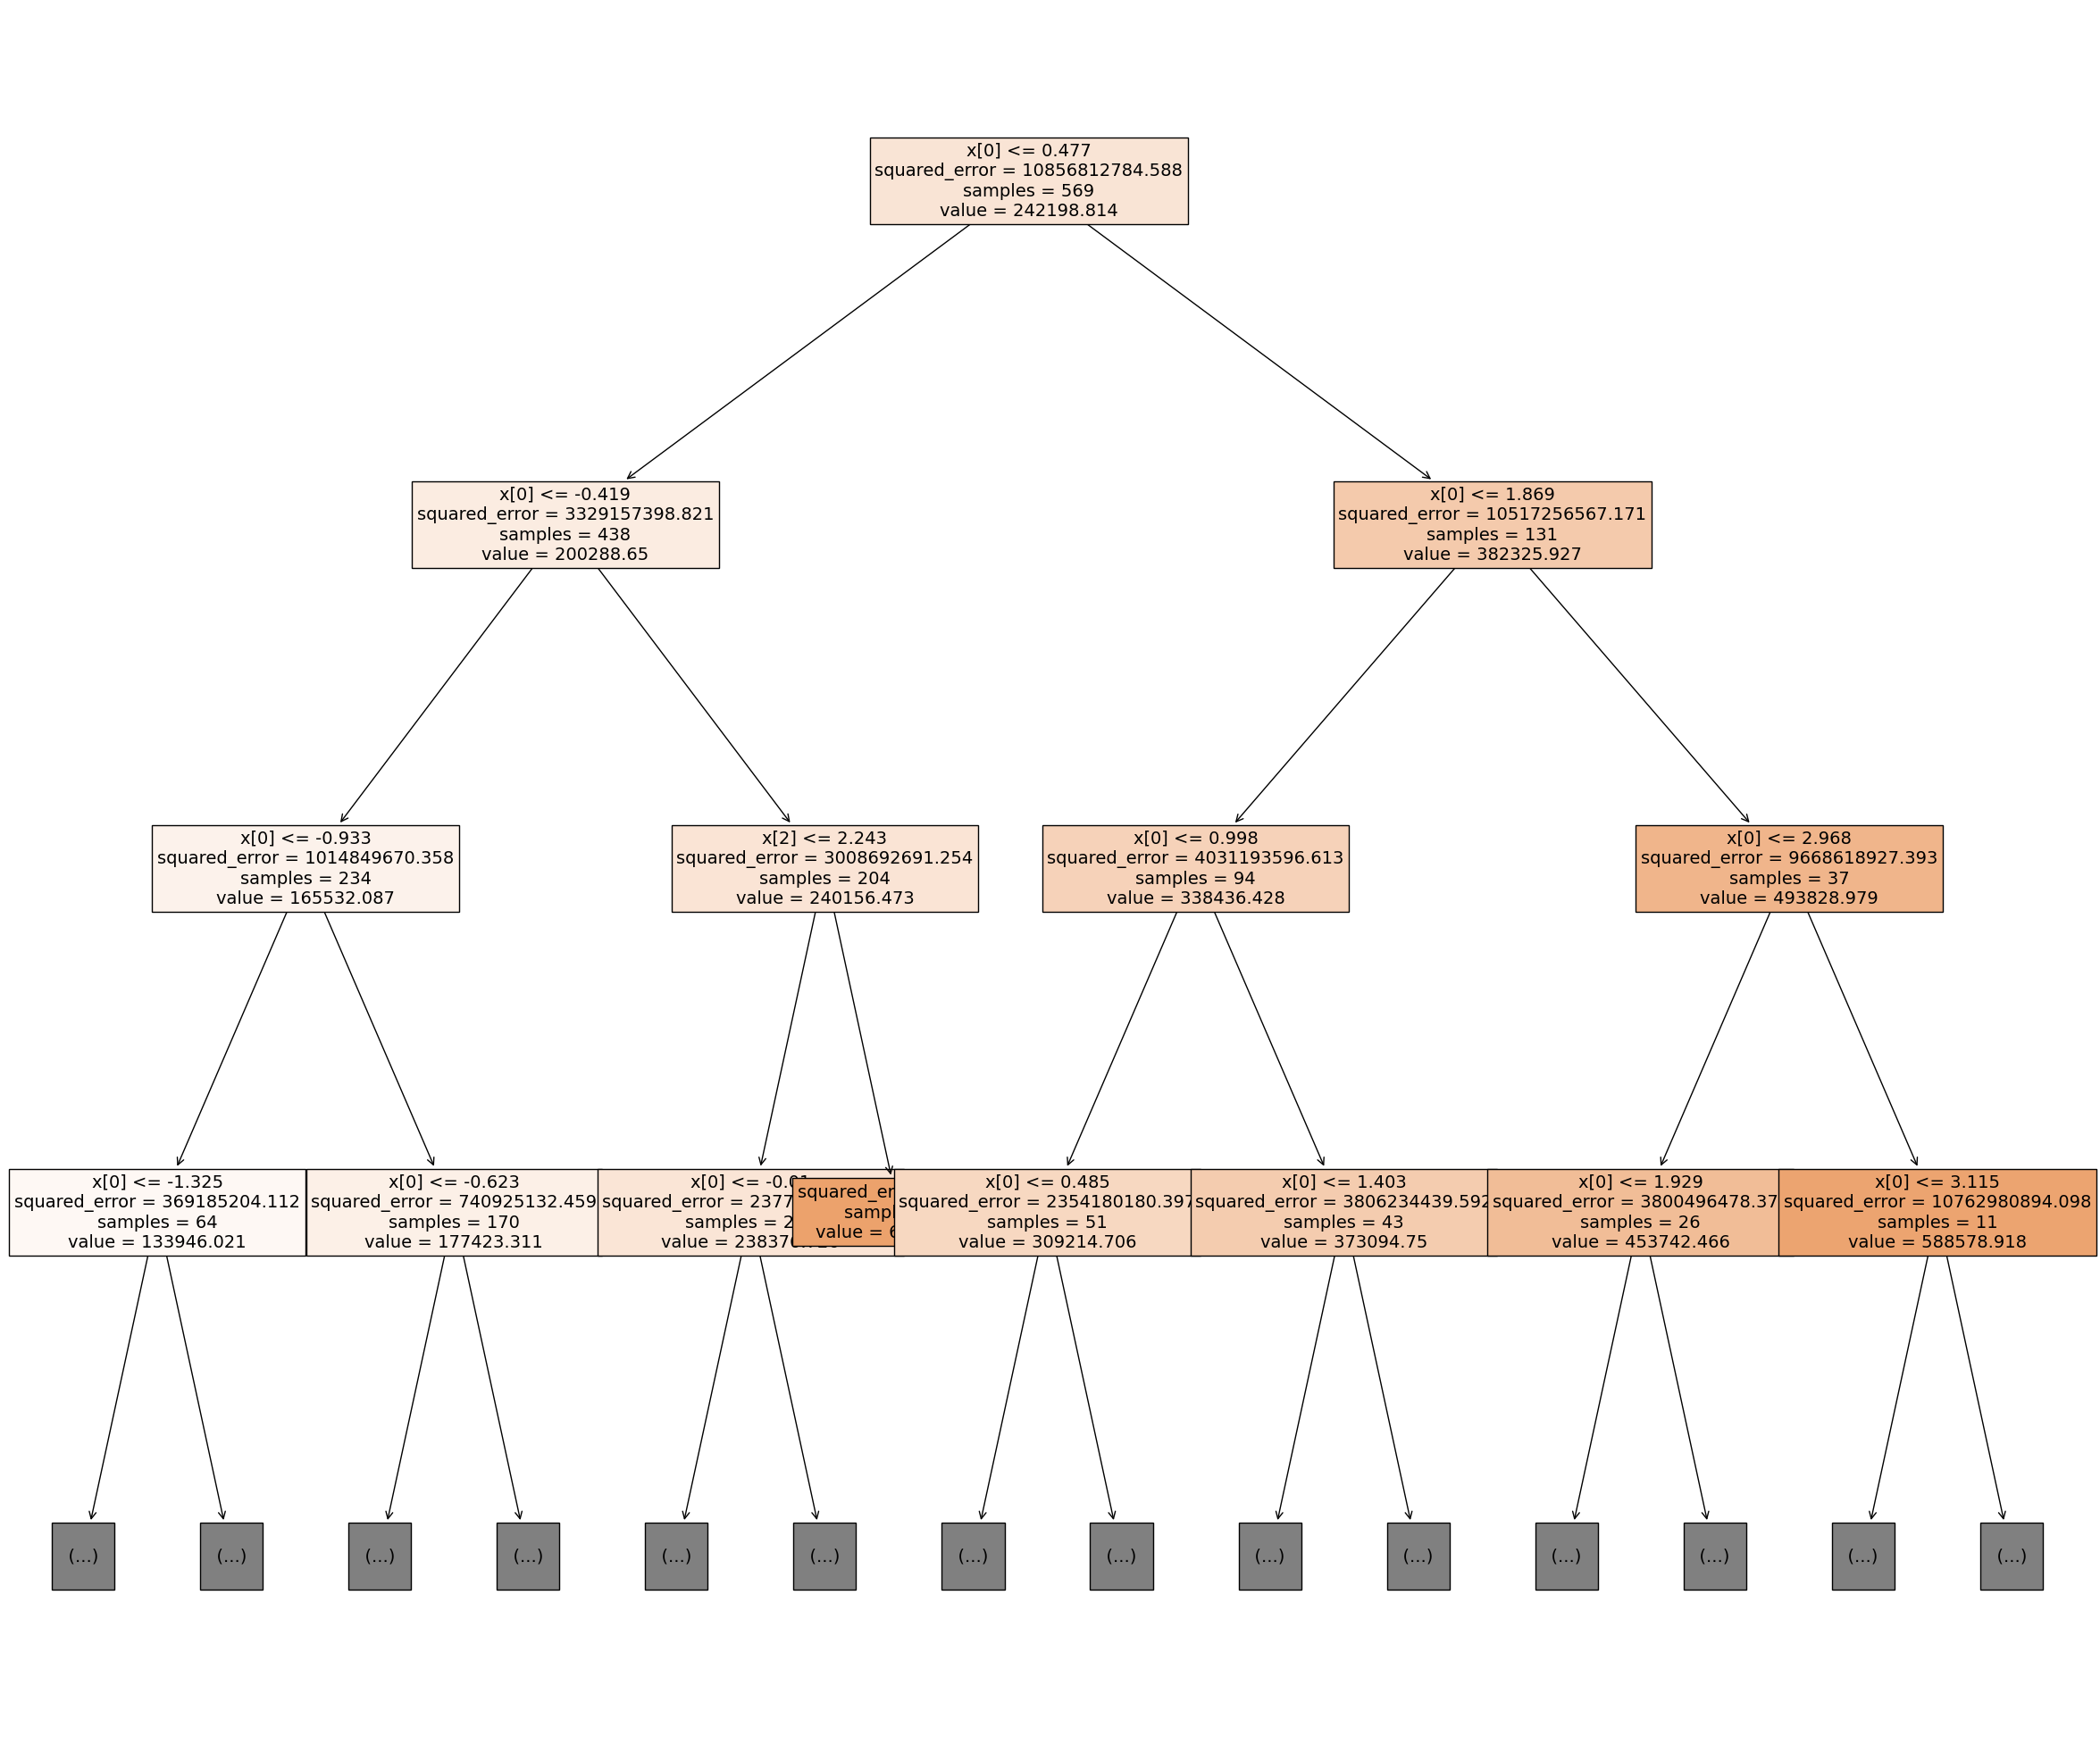

In [53]:
fig = plt.figure(figsize=(30,25))   
_ = plot_tree(
    model2.named_steps['dt'],
    filled = True,
    max_depth=3,
    fontsize=14,
)